# Descriptives Analytics of our database


In [1]:
import json
import os
import pickle
import psycopg2
import sqlalchemy
import pyproj
import time
import sys
sys.path.append("..")

import geopandas as gpd
from geopandas.geoseries import GeoSeries
from shapely.geometry import Point

import pandas as pd
import numpy as np


import matplotlib.pylab as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.animation as animation

from datetime import datetime
from dateutil.relativedelta import relativedelta
import imageio

from matplotlib.patches import Ellipse
%matplotlib inline

import seaborn as sns

from scipy.spatial import distance
import scipy.spatial.distance
from scipy.spatial.distance import cdist, pdist
import pylab as pl

from connect_db import db_connection

# filter annyoing warning from pandas
import warnings
warnings.filterwarnings('ignore')

In [2]:
username='ADD YOUR USERNAME HERE'

In [3]:
cred_location =  cred_location = "/mnt/data/{}/utils/data_creds_redshift.json.nogit".format(username)
db = db_connection.DBConnection(cred_location)

## Top 20 countries of origin of visitors across all time

In [71]:
query_mcc = """select mcc, count(customer_id) as num_unique_cus
        from tpt.tuscany.customer_feature        
        where customer_id not in (select customer_id from tuscany.excluded_customers)
        group by mcc
        order by num_unique_cus desc"""

In [72]:
number_of_cus_per_country = db.sql_query_to_data_frame(query_mcc, cust_id=True)

In [73]:
mcc=pd.read_csv('/mnt/data/shared/mcc-mnc-table.csv')

In [74]:
mcc_country=mcc.drop_duplicates("MCC", keep='first')[['MCC', 'Country']]

In [75]:
mcc_country['mcc']=mcc_country['MCC'].astype(int)

In [76]:
def clean_guam(row):
    if row['Country']=='Guam':
        return 'United States'
    else:
        return row['Country']

In [77]:
mcc_country['Country']=mcc_country.apply(clean_guam,1)

In [78]:
number_of_cus_country=number_of_cus_per_country.set_index('mcc').join(mcc_country.set_index('mcc'))[['Country','num_unique_cus']]

In [79]:
k=number_of_cus_country.groupby('Country').sum().sort_values('num_unique_cus', ascending=False)

Text(0,0.5,'')

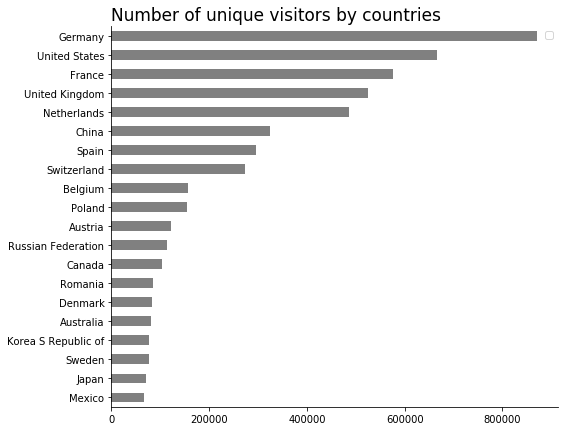

In [80]:
plt.rc("figure", figsize=(8, 7))
k[:20].sort_values('num_unique_cus').plot(kind='barh', color='grey')
sns.despine()
plt.title('Number of unique visitors by countries', loc='left', size=17)
plt.legend("")
plt.ylabel("")

## Number of visitors in Tuscany and Florence by month

In [4]:
query = """
select count(distinct customer_id), date_part('month',time_stamp) as mon 
from tuscany.vodafone
join tuscany.location_dictionary on vodafone.location_id = location_dictionary.location_id
where pro_com = 48017
group by mon
order by mon
"""

df_florence = db.sql_query_to_data_frame(query, cust_id=True)

In [5]:
query = """
select count(distinct customer_id), date_part('month',time_stamp) as mon
from tuscany.vodafone
join tuscany.location_dictionary on vodafone.location_id = location_dictionary.location_id
where pro_com != 48017
group by mon
order by mon
"""

df_rest_of_tuscany = db.sql_query_to_data_frame(query, cust_id=True)

In [6]:
df_florence = df_florence.merge(df_rest_of_tuscany,how='inner',left_on='mon',right_on='mon')

In [7]:
df_florence = df_florence.rename(columns={'count_x':'florence','count_y':'rest_of_tuscany'})

In [8]:
df_ordered = pd.concat([df_florence[2:],df_florence[:2]])

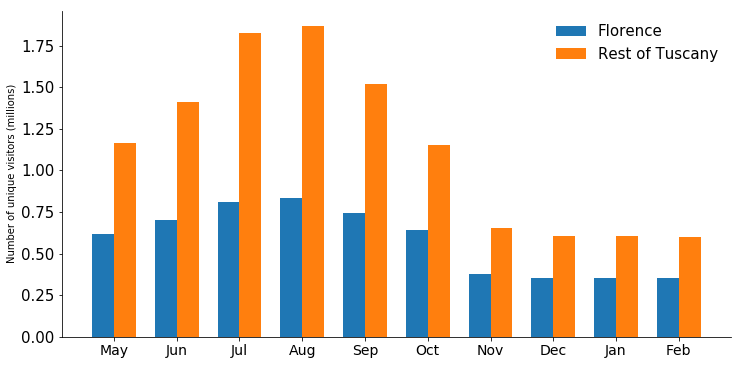

In [25]:
mon = np.arange(10)  # the x locations for the groups
width = 0.35       # the width of the bars
names = ['May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(mon, df_ordered['florence']/1000000, width)

rects2 = ax.bar(mon + width, df_ordered['rest_of_tuscany']/1000000, width)

# add some text for labels, title and axes ticks
ax.set_ylabel('Number of unique visitors (millions)')
#ax.set_title('Number of unique visitors (millions) by month')
ax.set_xticks(mon + width / 2)
ax.set_xticklabels(names)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.xticks(fontsize=14)
plt.yticks(fontsize=15)

ax.legend((rects1[0], rects2[0]), ('Florence','Rest of Tuscany'), loc='best', frameon=False, fontsize=15)



plt.show()

- Number of visitors in Florence and the rest of Tuscany both peak in the summer and drop in the winter
- Florence hosts less than one third of the total number of visitors in Tuscany during peak seasons (June to September), and more than one third during other months
- The difference between the peak season and off seasons in Florence is not as prominent as in the rest of Tuscany


## Heatmaps of numbers of visitors per territory by season

In [26]:
# Load maps data 

# load data from TPT (use this from now on)
regions = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Reg2016_WGS84_g/Reg_2016_WGS84_g.shp"
provinces = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/CMProv2016_WGS84_g/CMprov2016_WGS84_g.shp"
territories =  r"/mnt/data/shared/Tus_28districts.shp"
municipalities = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Com2016_WGS84_g/Com2016_WGS84_g.shp"

# important cities 
important_cities_tuscany = r"/mnt/data/shared/important_cities.csv"

In [27]:
# Load files and select only Tuscany
# reg, pro, mun are for the whole italy
# ter is only for tuscany, and already in lat,lon coords

gdf_reg = gpd.read_file(regions)
gdf_pro = gpd.read_file(provinces)
gdf_ter = gpd.read_file(territories)
gdf_mun = gpd.read_file(municipalities)

# Convert coordinates in WGS84 to Lat Lon format 
# see http://geopandas.org/projections.html
gdf_reg['geometry'] = gdf_reg['geometry'].to_crs(epsg=4326)
gdf_pro['geometry'] = gdf_pro['geometry'].to_crs(epsg=4326)
gdf_mun['geometry'] = gdf_mun['geometry'].to_crs(epsg=4326)

# important cities 
important_cities_tuscany = r"/mnt/data/shared/important_cities.csv"
df_impcit = pd.read_csv(important_cities_tuscany)

# 9 is for Tuscany only
gdf_reg_tus = gdf_reg[gdf_reg["COD_REG"] == 9] 
gdf_pro_tus = gdf_pro[gdf_pro["COD_REG"] == 9]
gdf_ter_tus = gdf_ter # this one is already Tuscany only
gdf_mun_tus = gdf_mun[gdf_mun["COD_REG"] == 9]

In [30]:
# Helper functions for plotting the heatmaps

def heatmap_plot(gdf_map, ax, clog=False, header='count', colorbar=True, title=False):
    """
    Plot the Point counts heatmap per municipality
    
    Params:
        gdf_map: GeoDataFrame with the 'header' field - it should NOT contain zeros
        axis: Axis object with the figure elements
        header: str with the name of the field to be ploted
        colorbar: bool, include or not a colorbar in the plot
    """
    
    # create the new log column
    header_log = 'log_'+header
    gdf_map[header_log] = np.log(gdf_map[header])
    
    # cash some useful values
    if clog is False:
        clog_min = np.round(gdf_map[header_log].min(), 6)
        clog_max = np.round(gdf_map[header_log].max(), 6)
    else:
        clog_min = np.round(clog[0], 6)
        clog_max = np.round(clog[1], 6)
    clog_range = np.linspace(clog_min, clog_max, num=5)
    
    # plot
    gdf_map.plot(column=header_log, ax=ax, 
                 vmin=clog_min, vmax=clog_max,
                 cmap='Reds',
                 edgecolor='gray',
                 alpha=0.6)
    
    if title is not False:
        ax.set_title(title, fontsize=15)
    
    if colorbar:
    
        norm = Normalize(vmin=clog_min, vmax=clog_max)
        n_cmap = cm.ScalarMappable(norm=norm, cmap='Reds')
        n_cmap.set_array([])
        
        cbar = ax.get_figure().colorbar(n_cmap, fraction=0.03, ticks=clog_range)
        
        cbar.ax.set_yticks(clog_range)
        cbar.ax.set_yticklabels((np.exp(clog_range)/1000).astype(int), fontsize=15)
        cbar.ax.set_ylabel('Number of unique visitors (thousands)', rotation=270, labelpad=25, fontsize=18) 
    
        
# there are 6 municipalities with 0 towers or visits:
# Capolona, Molazzana, Sassetta, Casale Maritimo, Filattiera, Tresana
def heatmap_replace_zeros(gdf_map, header='count'):
    """
    Replace zeros with the minimum positive count
    
    Params:
        gdf_map: GeoDataFrame with the 'header' field
        header: field in which zeros are replaced by the minimum value
    """    
    
    min_Point_count = np.array(gdf_map[header])
    gdf_map.loc[gdf_map[header]==0, header] = np.min(min_Point_count[np.nonzero(min_Point_count)])


def important_cities(df_impcit):
    """
    Include important cities in the plot
    
    Params:
        df_impcit: DataFrame with the 'lat', 'long', and 'city' fields
    """

    for i, name in enumerate(list(df_impcit.city)):
        plt.plot(df_impcit.long[i], df_impcit.lat[i], 'o', color='k', markersize=6)
        plt.annotate(name, (df_impcit.long[i]+0.03, df_impcit.lat[i]),
                     fontsize=15)

In [31]:
# function to run queries for the heatmap 
# this query already removes the customers from tuscany.excluded_customers

def query_count_territory(gdf_ter_map,
                          min_date = '2017-05-01 00:00:00', 
                          max_date = '2018-02-28 23:59:59'):
    '''
    Run the query for unique customers in each territory in a given time window
    
    Params:
        gdf_ter_map: GeoDataFrame with the field 'rown', loaded from /mnt/data/shared
        min_date: minimum date, in the yyy-mm-dd hh:mm:ss format
        max_date: maximum date, in the same format
        
    Returns:
        gdf_merged_map: GeoDataFrame with the unique counts for each territory
    '''

    query="""
    select count(distinct customer_id), location_dictionary.territory
    from tuscany.vodafone
    join tuscany.location_dictionary on location_dictionary.location_id = vodafone.location_id
    where time_stamp between '"""+min_date+"""' and '"""+max_date+"""'
    and customer_id not in (select customer_id from tuscany.excluded_customers)
    and territory is NOT NULL
    group by tuscany.location_dictionary.territory;
    """
    df_count_territory = db.sql_query_to_data_frame(query, cust_id=True)
    
    gdf_merged_map = gdf_ter_map.merge(df_count_territory.astype(int), how = 'inner', left_on='rown', right_on='territory')
    
    return gdf_merged_map

In [33]:
# queries for each 'seasonality'

# # create dictionary with heatmaps for every month
# heatmaps_per_season = {}

# create months datetime list
# minimum date is '2017-05-01 00:00:00'
# maximun date is '2017-28-02 23:59:59'
start_dt = str(datetime(2017, 4, 30, hour=23, minute=59, second=59))
end_dt = str(datetime(2017, 5, 31, hour=23, minute=59, second=59))
gdf_season = query_count_territory(gdf_ter_tus, min_date = start_dt, max_date = end_dt)
heatmaps_per_season['Pre-summer'] = gdf_season  
print('Pre-summer')

start_dt = str(datetime(2017, 5, 31, hour=23, minute=59, second=59))
end_dt = str(datetime(2017, 8, 31, hour=23, minute=59, second=59))
gdf_season = query_count_territory(gdf_ter_tus, min_date = start_dt, max_date = end_dt)
heatmaps_per_season['Summer'] = gdf_season  
print('Summer')

start_dt = str(datetime(2017, 8, 31, hour=23, minute=59, second=59))
end_dt = str(datetime(2017, 10, 31, hour=23, minute=59, second=59))
gdf_season = query_count_territory(gdf_ter_tus, min_date = start_dt, max_date = end_dt)
heatmaps_per_season['Post-summer'] = gdf_season  
print('Post-summer')

start_dt = str(datetime(2017, 10, 31, hour=23, minute=59, second=59))
end_dt = str(datetime(2018, 2, 28, hour=23, minute=59, second=59))
gdf_season = query_count_territory(gdf_ter_tus, min_date = start_dt, max_date = end_dt)
heatmaps_per_season['Winter'] = gdf_season  
print('Winter')

Pre-summer
Summer
Post-summer
Winter


In [34]:
# normalize the seasonality maps

heatmaps_per_season['Pre-summer']['count'] = heatmaps_per_season['Pre-summer']['count']
heatmaps_per_season['Summer']['count'] = heatmaps_per_season['Summer']['count']/3
heatmaps_per_season['Post-summer']['count'] = heatmaps_per_season['Post-summer']['count']/2
heatmaps_per_season['Winter']['count'] = heatmaps_per_season['Winter']['count']/4

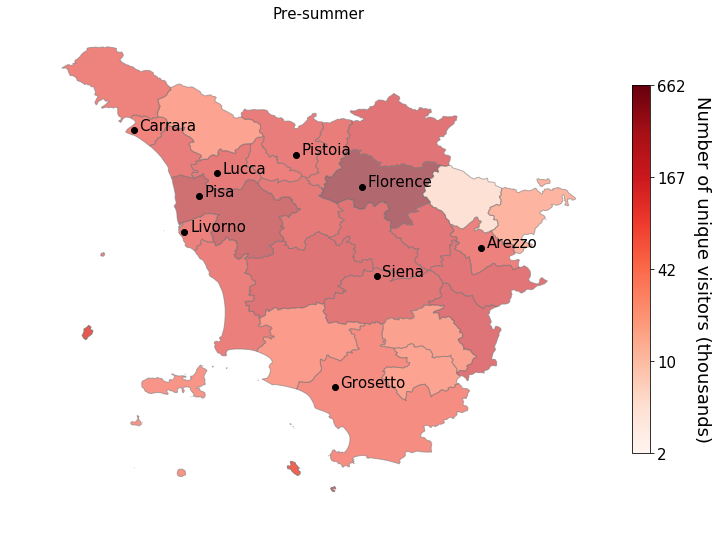

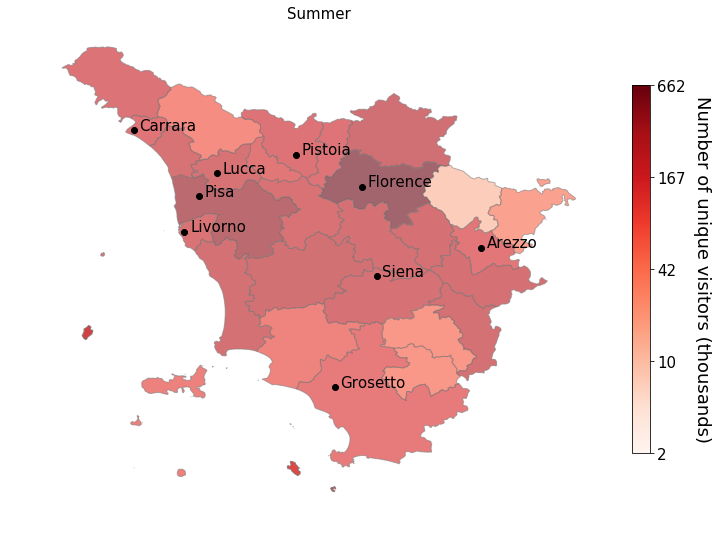

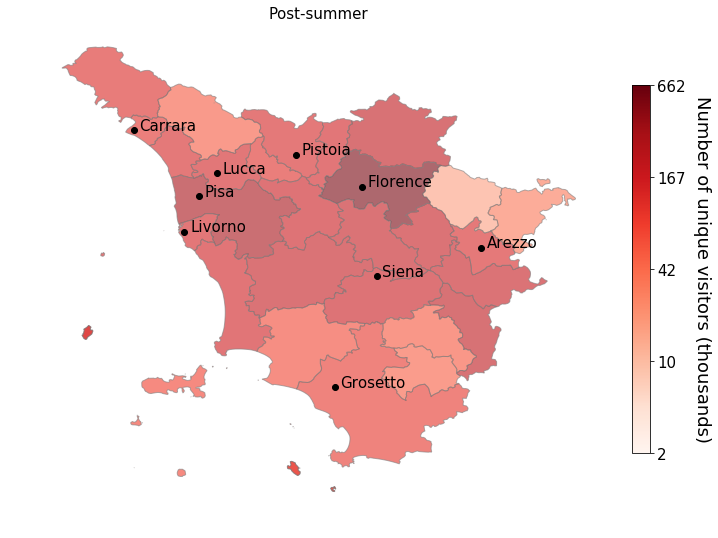

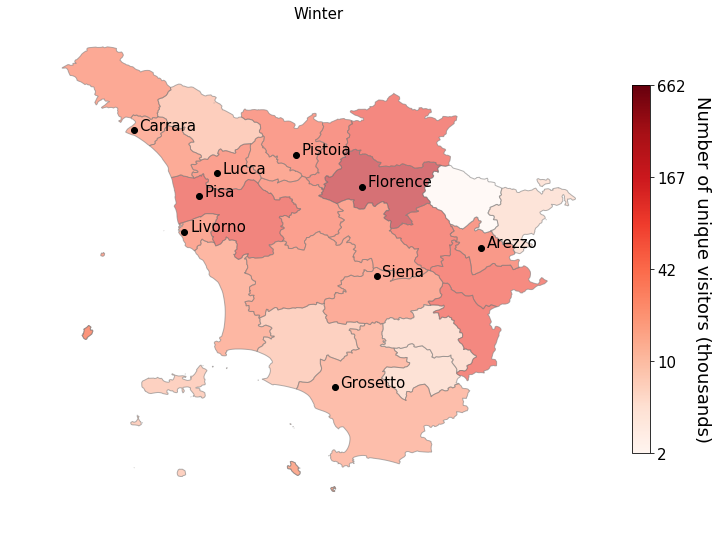

In [36]:
# heatmap plots for each season

# find overall minimum and maximum
min_count_season = []
max_count_season = []
for season, gdf_season in heatmaps_per_season.items():   
    min_count_season.append(gdf_season['count'].min())
    max_count_season.append(gdf_season['count'].max())
min_count = np.array(min_count_season).min()
min_logcount = np.log(min_count)
max_count = np.array(max_count_season).max()
max_logcount = np.log(max_count)

# create monthly heatmaps
for season, gdf_season in heatmaps_per_season.items():
    
    fig = plt.figure(figsize=(11, 9))
    ax = fig.add_subplot(1, 1, 1)    
    
    heatmap_replace_zeros(gdf_season)
    heatmap_plot(gdf_season, ax, clog=[min_logcount, max_logcount], title=season)  
    important_cities(df_impcit)
    
    plt.axis('off')
    #plt.savefig(r"/mnt/data/shared/heatmaps/monthly/"+season+".png", transparent=True)

## Number of days spent in Tuscany

In [9]:
query_hrs = """select hrs_in_italy, hrs_in_tusc
        from tpt.tuscany.customer_feature
        where customer_id not in (select customer_id from tuscany.excluded_customers)"""  

In [10]:
df_hrs = db.sql_query_to_data_frame(query_hrs, cust_id=True)


In [11]:
df_hrs['days_in_tusc'] = df_hrs['hrs_in_tusc']/24

In [12]:
df_hrs[df_hrs.columns]=df_hrs[df_hrs.columns].astype(float)

In [23]:
len(df_hrs[(df_hrs['days_in_tusc']>=6) & (df_hrs['days_in_tusc']<=10)])/len(df_hrs)

0.14781122124274418

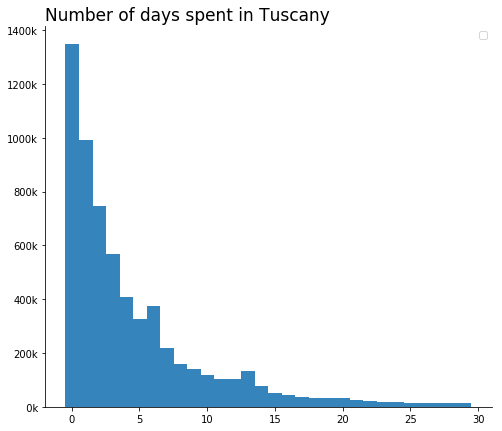

In [27]:
fig, ax1 = plt.subplots(figsize=(8, 7))
ax1.hist(df_hrs.days_in_tusc, 30,  alpha=0.9, label="Sample1",align='left')
y_vals = ax1.get_yticks()
ax1.set_yticklabels(['{:3.0f}k'.format(x * .001) for x in y_vals])
sns.despine()
plt.title('Number of days spent in Tuscany', loc='left', size=17)
plt.legend("")
plt.ylabel("")
plt.show()

- 21% spent less than 1 day in Tuscany

- 45% spent 1-5 days in Tuscany

- 15% spent 6-10 days in Tuscany


## Ratio of number of visitors from the top five countries, by month

In [38]:
# query to get the nationalities that visited Tuscany

def query_count_nationality(min_date = '2017-05-01 00:00:00', 
                            max_date = '2018-02-28 23:59:59'):
    
    query="""select mcc, count(distinct customer_id) as num_unique_cus
    from tuscany.vodafone
    where time_stamp between '"""+min_date+"""' and '"""+max_date+"""'
    and customer_id not in (select customer_id from tuscany.excluded_customers)
    group by mcc"""

    number_of_cus_per_country = db.sql_query_to_data_frame(query, cust_id=True)
    
    return number_of_cus_per_country

In [39]:
# create months datetime list
# minimum date is '2017-05-01 00:00:00'
# maximun date is '2017-28-02 23:59:59'
start_dt = datetime(2017, 4, 30, hour=23, minute=59, second=59)
end_dt = datetime(2018, 2, 28, hour=23, minute=59, second=59)
months_dt = []
for i in pd.date_range(start=start_dt, end=end_dt, freq='1M'):
    months_dt.append(str(i + relativedelta(hour=23, minute=59, second=59)))
    
# create dictionary with nationalities for every month
nationality_per_month = {}
for i in range(len(months_dt)-1):
    
    month_start = months_dt[i]
    month_end = months_dt[i+1]
    
    nat_month = query_count_nationality(min_date = month_start, max_date = month_end)
    cur_month = datetime.strptime(months_dt[i+1], "%Y-%m-%d %H:%M:%S").strftime("%B")
    
    nationality_per_month[cur_month] = nat_month  
    print(cur_month)

May
June
July
August
September
October
November
December
January
February


In [ ]:
# get the country names from the MCC file and create a column with country name

def clean_guam(row):
    if row['Country']=='Guam':
        return 'United States'
    else:
        return row['Country']

mcc=pd.read_csv('/mnt/data/shared/mcc-mnc-table.csv')
mcc_country=mcc.drop_duplicates("MCC", keep='first')[['MCC', 'Country']]
mcc_country['MCC']=mcc_country['MCC'].astype(int)
mcc_country['Country']=mcc_country.apply(clean_guam,1)


for month, df_nat in nationality_per_month.items():
    df_nat['mcc'] = df_nat['mcc'].astype(int)
    nationality_per_month[month] = df_nat.merge(mcc_country, how = 'inner', left_on='mcc', right_on='MCC')


In [41]:
# shrink the data for the top countries (the others should be in a separate field called others)

for month in nationality_per_month.keys():
    nationality_per_month[month] = nationality_per_month[month].sort_values(by=['num_unique_cus'], ascending=False)
    nationality_per_month[month] = nationality_per_month[month].groupby('Country', as_index=False).aggregate('sum')
    nationality_per_month[month] = nationality_per_month[month].drop(['mcc', 'MCC'], axis=1)

In [42]:
# find top countries overall
df_counts = pd.DataFrame(nationality_per_month['May']['Country'], columns=['Country'])
for month in list(nationality_per_month.keys())[:]:
    df_counts = df_counts.merge(nationality_per_month[month], how='outer', left_on='Country', right_on='Country')
    df_counts = df_counts.rename(columns={'num_unique_cus': month})
df_counts = df_counts.fillna(0)


# group countries

N_TOPLOT = 9

# find countries with biggest counts
df_counts['Sum'] = df_counts.sum(axis=1)
df_counts = df_counts.sort_values('Sum', ascending=False)
df_counts = df_counts.head(N_TOPLOT)
df_counts = df_counts.drop(columns=['Sum'])


In [43]:
relevant=[]
for col in df_counts.columns:
    if col.lower()[:3]!='mcc':
        relevant.append(col)

In [47]:
counts=df_counts[relevant].set_index('Country').T.T[:-4].T

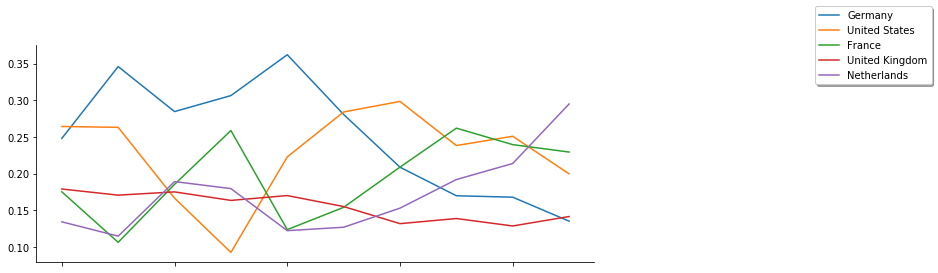

In [48]:
df=(counts.T / counts.T.sum()).T
ax=df.plot(figsize=(10,4))
sns.despine(top=True, right=True, bottom=False
            ,left=False)
ax.legend(loc='upper center', bbox_to_anchor=(1.5, +1.2),
          fancybox=True, shadow=True, ncol=1)

- German tourists account for the largest fractions in the summer, peaking in June and September. 

- Ratios of American tourists are highest pre and post-summer times.

- Higher ratios of French and Dutch tourists in winter months as compared to the summer. 

- Ratios of British tourists are evenly distributed throughout the year.
